# Dogs life expectancy predictors
Data from Wallis LJ, Szabó D, Erdélyi-Belle B, Kubinyi E. Demographic Change Across the Lifespan of Pet Dogs and Their Impact on Health Status. Front Vet Sci. 2018 Aug 23;5:200. doi: 10.3389/fvets.2018.00200. PMID: 30191153; PMCID: PMC6115627.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

In [2]:
def histogrammer(df, column_str, median_text=True, **kwargs):    # **kwargs = any keyword arguments
    """
    Plots a histogram of a given column of a dataframe with a vertical line at the median.

    Args:
        df (pd.DataFrame): The dataframe containing the column to plot.
        column_str (str): The name of the column to plot.
        median_text (bool): Whether to display the median value on the plot.
        **kwargs: Additional keyword arguments for the histogram.
    """              
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=df[column_str], **kwargs)            # Plot the histogram
    plt.axvline(median, color='red', linestyle='--')         # Plot the median line
    if median_text==True:                                    # Add median text unless set to False
        ax.text(0.75, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram')
    plt.show()

In [3]:
def outlier_imputer(df, column_name, percentile):
    """
    Impute outliers in a given column of a dataframe with the threshold value.

    Args:
        df (pd.DataFrame): The dataframe containing the column to impute.
        column_name (str): The name of the column to impute.
        percentile (float): The percentile to use as the threshold.

    Returns:
        pd.DataFrame: The dataframe with the imputed outliers.
    """
    # Calculate threshold
    threshold = df[column_name].quantile(percentile)

    if np.any(df[column_name] > threshold):
        count = np.sum(df[column_name] > threshold)
        percentage = (count/len(df))*100

        print(f'{column_name} : {count} outliers imputed, representing {round(percentage, 4)}%')

        # Impute threshold for values > than threshold
        df.loc[df[column_name] > threshold, column_name] = threshold
    
    return df

#### Load dataset

In [4]:
df = pd.read_excel('Data_Sheet_1_Demographic_Change_Across_the_Lifespan_of_Pet_Dogs_and_Their_Impact_on_Health_Status.XLSX', sheet_name='QUESTIONNAIRE')

## Exploratory Data Analysis

In [5]:
df.head()

,id,Health_status,Sex,Age_in_months,Age_group,Height,Weight,Breed,Neuter_status,Sensory_problems,...,Life_event_mating_pregnancy,Life_event_change_in_family_structure,Life_event_No_dogs_household_changed,Life_event_moved_house,Life_event_changed_owners,Life_event_spent_more_time_alone,Life_event_lost,Life_event_injury_surgery,Life_event_spent_time_at_shelter,Life_events
0,dog2,0,2,139,5,43,9,2,1,0,...,0,0,1,0,0,0,0,1,0,1
1,dog3,1,2,128,5,50,15,1,1,0,...,1,0,0,0,0,0,0,0,0,0
2,dog4,0,2,111,4,53,35,1,2,0,...,0,1,1,1,0,1,0,0,0,2
3,dog5,0,2,164,6,55,20,1,1,0,...,1,1,1,0,0,0,0,0,0,1
4,dog6,0,2,147,6,46,14,2,2,0,...,1,1,1,0,0,1,0,0,0,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     1207 non-null   object
 1   Health_status                          1207 non-null   int64 
 2   Sex                                    1207 non-null   int64 
 3   Age_in_months                          1207 non-null   int64 
 4   Age_group                              1207 non-null   int64 
 5   Height                                 1207 non-null   int64 
 6   Weight                                 1207 non-null   int64 
 7   Breed                                  1207 non-null   int64 
 8   Neuter_status                          1207 non-null   int64 
 9   Sensory_problems                       1207 non-null   int64 
 10  Offleash_activity                      1207 non-null   int64 
 11  Body_condition_sc

All variables are of type int64 except for the id which is of type object. 

There are no missing data. 

In [7]:
# Explore possible values for each column
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'id': ['dog2' 'dog3' 'dog4' ... 'dog1372' 'dog1373' 'dog1374']
Unique values in column 'Health_status': [0 1]
Unique values in column 'Sex': [2 1]
Unique values in column 'Age_in_months': [139 128 111 164 147 102  99 122  69 151  97 138  42  63  41  56 133  67
  59 132 127 124  96 153 172 115 159 204 109  84 145 134  92 218  77  26
 170  52 121  25  49  16 106  27  43  94  79  48 180  72  85  45  73 154
 117 125  78 162 110 123  46 130 126 188  37  61  89 152 114  80  90 119
 131  75 101 193 186  57  21  93 120 108 189 144  86  35  82  38  12 192
  39  81  31  40  51  17 158  98  71  14  65  29 169  54  18  60 182  88
  62 129 107 196 163  24  20  33 198  28  30 173  36  34  50 116 181  68
  55 100  76  87 137  64 168  47  32 176 148  15  13 113 141 146 136 103
 112 165  66 157  44 194 199  95 104  22 105 135 206 155 156  70 150  83
 185 161  91  53 149 143 171 178  19 140 197 316  23 210  58  74 166 183
 142 118 208 253 265 160 190 167 179 216 214]
Unique value

Remove redundant columns: 
- Information in Age_group is included in Age_in_months
- All the life events are included in Life_events
- Health problems and Sensory problems : were used to code healthy vs unhealthy dogs 
- Medication and Dog_beh_changed_3month : probably reflect health problems, not predictors.

In [8]:
df = df.drop(columns = ['id','Age_group', 'Life_event_mating_pregnancy', 'Life_event_change_in_family_structure',
                        'Life_event_No_dogs_household_changed', 'Life_event_moved_house',
                        'Life_event_changed_owners', 'Life_event_spent_more_time_alone',
                        'Life_event_lost', 'Life_event_injury_surgery', 'Life_event_spent_time_at_shelter', 
                        'Health_problems', 'Sensory_problems', 'Medication', 'Dog_beh_changed_3month'])

In [9]:
# Variables categorization
categorical_var = ['Sex', 'Breed', 'Neuter_status', 'Trauma', 'Owner_gender', 
                   'Child', 'get_dog', 'Food', 'Where_dog_is_kept']
continuous_var = ['Age_in_months', 'Height', 'Weight']
ordinal_var = ['Offleash_activity', 'Body_condition_score', 'Vitamins', 
               'Owner_age', 'Owner_experience', 'Other_dogs_in_house', 
               'People_in_household', 'Age_of_dog_when_arrived', 
               'Dog_obedience_tasks', 'Play', 'Commands', 'Dog_training_activities', 
               'Time_dog_spend_alone', 'Life_events']

Variables recoding

In [10]:
# some binary variables are coded 1-2 instead of 0-1, so correct it
for col in df.columns:
    if set(df[col].unique()) == {1, 2}:
        df[col] = df[col].replace({1: 0, 2: 1})

# Body_condition_score will be recoded from smaller to bigger into an ordinal variable
df['Body_condition_score'] = df['Body_condition_score'].replace({2: 3, 3: 2})

# Recode Health_status: Healthy = 0, Unhealthy = 1 by reversing the current encoding (0->1, 1->0)
df['Health_status'] = df['Health_status'].replace({0: 1, 1: 0})

In [11]:
# Verify dependent variable class balance
df['Health_status'].value_counts(normalize=True)

Health_status
1    0.605634
0    0.394366
Name: proportion, dtype: float64

More unhealthy than healthy dogs, but the class imbalance is not too important so continue analyses. 

#### Features inspection and creation

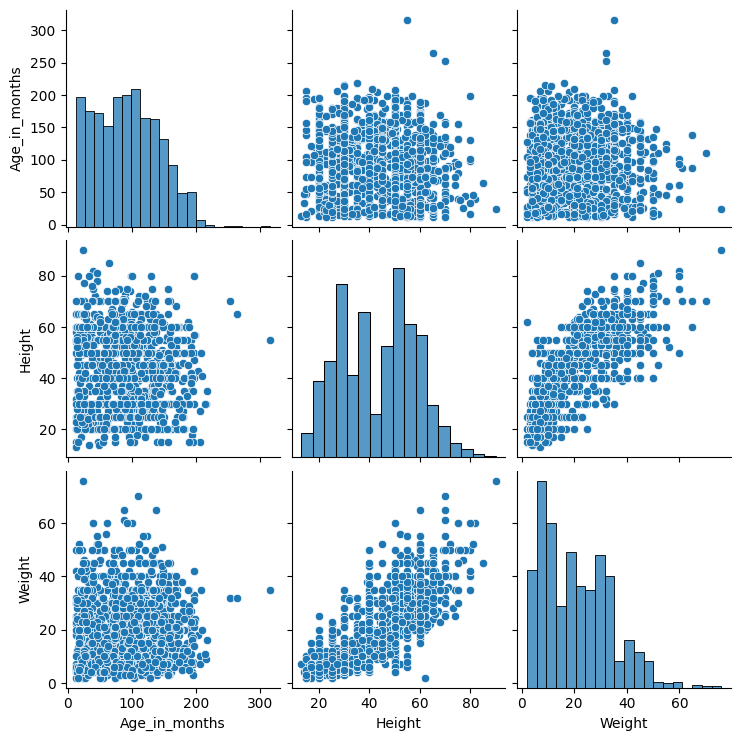

In [12]:
sns.pairplot(df[continuous_var])
plt.show()

Height and weight are correlated, so a new feature for their ratio weight/height is created.

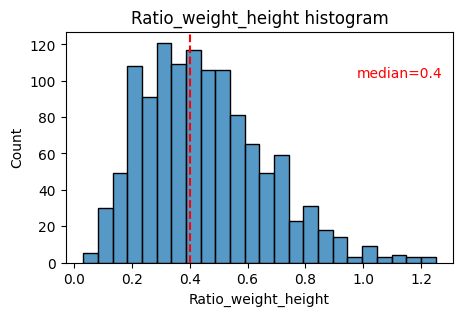

count    1207.000000
mean        0.451560
std         0.209475
min         0.032258
25%         0.300000
50%         0.428571
75%         0.581607
max         1.250000
Name: Ratio_weight_height, dtype: float64

In [13]:
df['Ratio_weight_height'] = df['Weight']/df['Height']
df = df.drop(columns = ['Weight', 'Height']) # update dataframe
continuous_var = list(set(continuous_var) - set(['Weight', 'Height'])) +  ['Ratio_weight_height'] # update continuous variables list

histogrammer(df, 'Ratio_weight_height')

df['Ratio_weight_height'].describe()

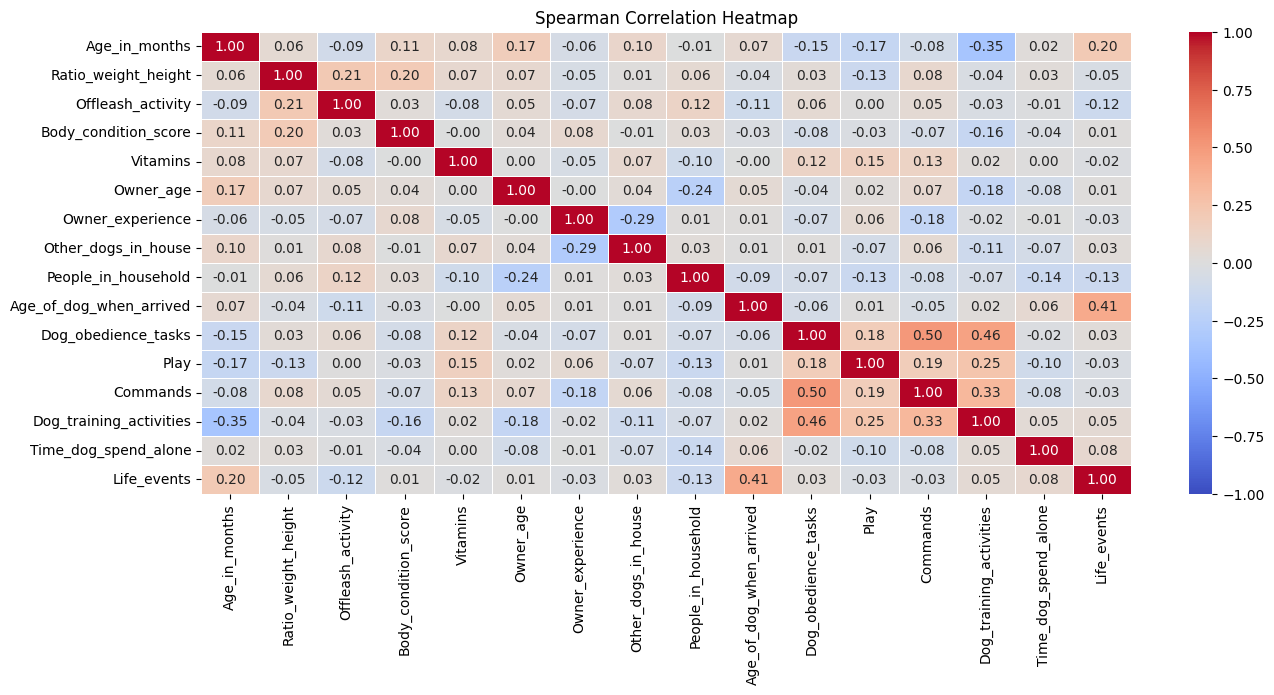

In [14]:
# spearman correlation to explore correlation between non categorical variables
corr = df[continuous_var + ordinal_var].corr(method='spearman')

plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

Dog_obedience_tasks, Commands, Dog_training_activities are correlated and represent similar information. They are combined into a new feature. 

In [15]:
# Z score per variable to get same scales and average  
scaler = StandardScaler()
X = scaler.fit_transform(df[["Dog_obedience_tasks", "Commands", "Dog_training_activities"]])

df['Training_level'] = X.mean(axis=1)


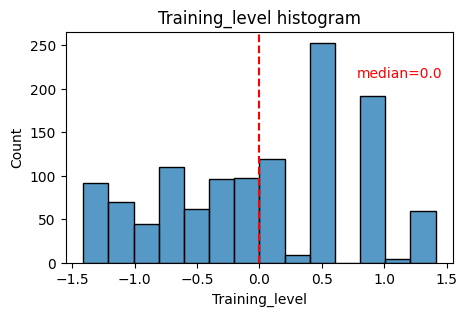

In [16]:
histogrammer(df, 'Training_level')

The variables previously combined into features and Body_condition_score because it is redundant with ratio_weight_height are removed. 

In [17]:
df = df.drop(columns = ["Dog_obedience_tasks", "Commands", "Dog_training_activities", "Body_condition_score"]) # update dataframe
# add Training_level to ordinal_var and variables combined 
ordinal_var = list(set(ordinal_var) - set(["Dog_obedience_tasks", "Commands", "Dog_training_activities", "Body_condition_score"]) | set(['Training_level'])) # update ordinal variables list 

#### Check for outliers in continuous variables
Values are considered outliers when > than 95th percentile and replaced with this value. 

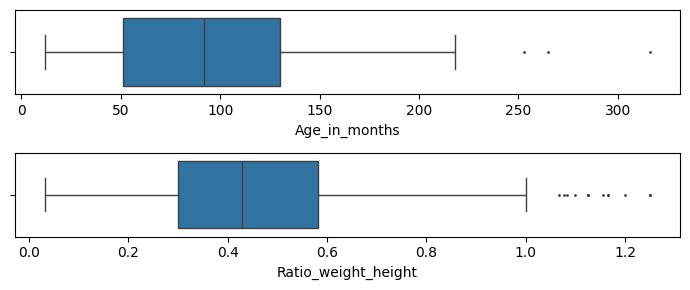

In [18]:
fig, axes = plt.subplots(len(continuous_var), 1, figsize=(7, 3))

for i in range(len(continuous_var)):
    sns.boxplot(x=df[continuous_var[i]], fliersize=1, ax=axes[i])

plt.tight_layout()
plt.show()

In [19]:
percentile = 0.95 # percentile after which value is considered outlier and imputed

for var in continuous_var:
    outlier_imputer(df, var, percentile)

Age_in_months : 60 outliers imputed, representing 4.971%
Ratio_weight_height : 58 outliers imputed, representing 4.8053%


Under 5% of outliers, so considered ok. 

## Logistic regression

### Assumptions
* Independent observations : we assume independance of observations 

* No extreme outliers : outliers identified and imputed, less than 5% for continuous variables

* Little to no multicollinearity among X predictors

* Linear relationship between continuous X predictors and the **logit** of y : will be verified after modeling

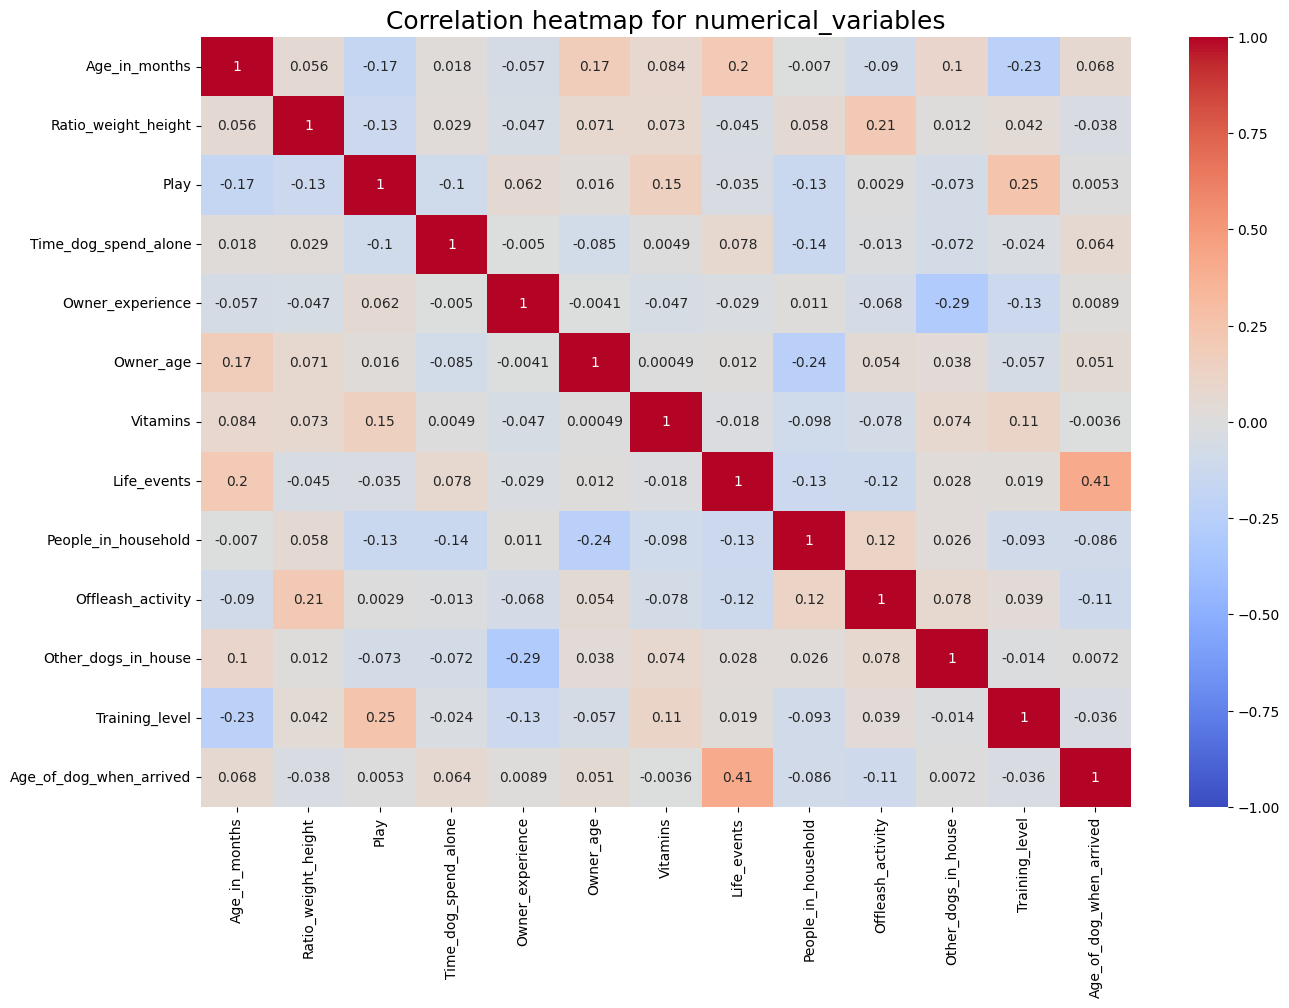

In [20]:
# Check for multicollinearity (using spearman correlation for ordinal variables)
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df[continuous_var+ordinal_var].corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap for numerical_variables',
          fontsize=18)
plt.show();

No correlation higher than chosen 0.6 threshold, so multicolinerity respected. 

### Model 

In [21]:
X = df[['Sex', 'Breed', 'Food', 'Owner_age', 'Life_events', 'Ratio_weight_height', 'Training_level']]
y = df['Health_status']

In [22]:
formula = 'Health_status ~ C(Sex) + C(Breed) + C(Food)+ C(Owner_age) + Life_events + Ratio_weight_height + Training_level'
# Fit the logistic regression model
model = smf.logit(formula, data=df)

result = model.fit()

# Print the summary of the model
print(result.summary())
# https://dadataguy.medium.com/logistic-regression-using-statsmodels-a63e7944de76


Optimization terminated successfully.
         Current function value: 0.639907
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          Health_status   No. Observations:                 1207
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                           12
Date:                Sat, 10 Jan 2026   Pseudo R-squ.:                 0.04586
Time:                        13:06:39   Log-Likelihood:                -772.37
converged:                       True   LL-Null:                       -809.49
Covariance Type:            nonrobust   LLR p-value:                 5.111e-11
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0809      0.273     -0.297      0.767      -0.615       0.454
C(

In [23]:
coefficients = result.params.values
p_values = result.pvalues.values
variable_names = result.params.index.values

# Calculate Odds Ratios
odds_ratios = np.exp(coefficients)

# Create a summary dataframe
predictor_summary = pd.DataFrame({
    'Variable': variable_names,
    'Coefficient': coefficients,
    'Odds_Ratio': odds_ratios,
    'Abs_Coefficient': np.abs(coefficients),
    'perc_comparison': (odds_ratios-1)*100, 
    'p_value': p_values
})

# Sort by absolute coefficient (importance)
predictor_summary = predictor_summary.sort_values('Abs_Coefficient', ascending=False)

print("=" * 50)
print("PREDICTOR IMPORTANCE SUMMARY")
print("=" * 50)
print(predictor_summary[['Variable', 'Coefficient', 'Odds_Ratio', 'perc_comparison', 'p_value']].to_string())

PREDICTOR IMPORTANCE SUMMARY
               Variable  Coefficient  Odds_Ratio  perc_comparison       p_value
6          C(Food)[T.5]    -0.726998    0.483358       -51.664206  2.540074e-04
5          C(Food)[T.4]    -0.465659    0.627722       -37.227843  1.209869e-02
10          Life_events     0.355441    1.426810        42.680985  5.060628e-08
2         C(Breed)[T.1]     0.344675    1.411531        41.153136  1.291274e-02
3          C(Food)[T.2]    -0.314107    0.730441       -26.955926  1.584774e-01
8     C(Owner_age)[T.3]     0.273032    1.313942        31.394191  1.118191e-01
12       Training_level    -0.269805    0.763528       -23.647174  9.470729e-04
7     C(Owner_age)[T.2]     0.256103    1.291885        29.188526  1.079311e-01
1           C(Sex)[T.1]    -0.241364    0.785555       -21.444461  5.231281e-02
11  Ratio_weight_height     0.140677    1.151053        15.105307  6.589194e-01
0             Intercept    -0.080911    0.922276        -7.772379  7.666865e-01
9     C(Own

**Significant Predictors (p < 0.05):**

**Food:**
- Eating only raw food (Food_5) is associated with 52% lower odds of being unhealthy compared to eating only dry food (reference), with all other variables maintained constant (p < 0.001).
- Eating mixed food (Food_4) is associated with 37% lower odds of being unhealthy compared to eating only dry food, with all other variables maintained constant (p = 0.012).

**Note:** Food_2 (tinned and dry food, p = 0.158) and Food_3 (cooked food, p = 0.940) were not statistically significant and are not interpreted.

**Recommendation:** Feeding regimes other than dry food only, particularly raw and mixed diets, are significantly associated with lower odds of poor health. However, food choice is likely related to other factors like owner engagement, socioeconomic background, etc.

**Training:**
- An increase in one unit of training level is associated with 24% lower odds of being unhealthy, with all other variables maintained constant (p < 0.001).

**Recommendation:** More training is significantly associated with better health outcomes.

**Breed:**
- Pure breed dogs are associated with 41% higher odds of being unhealthy than mixed breed dogs, with all other variables maintained constant (p = 0.013).

**Life Events:**
- An increase in one unit of life events is associated with 43% higher odds of being unhealthy, with all other variables maintained constant (p < 0.001).

**Non-Significant Predictors (p ≥ 0.05):**
- Sex (p = 0.052): Marginally significant but not statistically significant at α = 0.05
- Owner_age categories (p = 0.108-0.756): Not statistically significant
- Ratio_weight_height (p = 0.659): Not statistically significant

These non-significant predictors suggest that the observed effects could be due to chance, and no meaningful conclusions should be drawn from them. 

#### Verify linear relationship between logit and predictors

In [24]:
# Verify linear relationship between logit and continuous predictors (Ratio_weight_height, Training_level, life_events)
# Get the predicted probabilities
pred_proba = result.predict(which="linear") # which="linear" to get the logit (linear predictor)

# Copy the X dataframe and assign to logit_data
logit_data = X[["Ratio_weight_height", "Training_level", "Life_events"]].copy()

# Create a new logit column in the logit_data df
logit_data['logit'] = pred_proba
logit_data.head()

,Ratio_weight_height,Training_level,Life_events,logit
0,0.209302,-1.102109,1,0.512013
1,0.300000,-0.346599,0,-0.596943
2,0.660377,0.099706,2,0.454606
3,0.363636,-0.463907,1,0.465589
4,0.304348,0.017405,2,0.317435


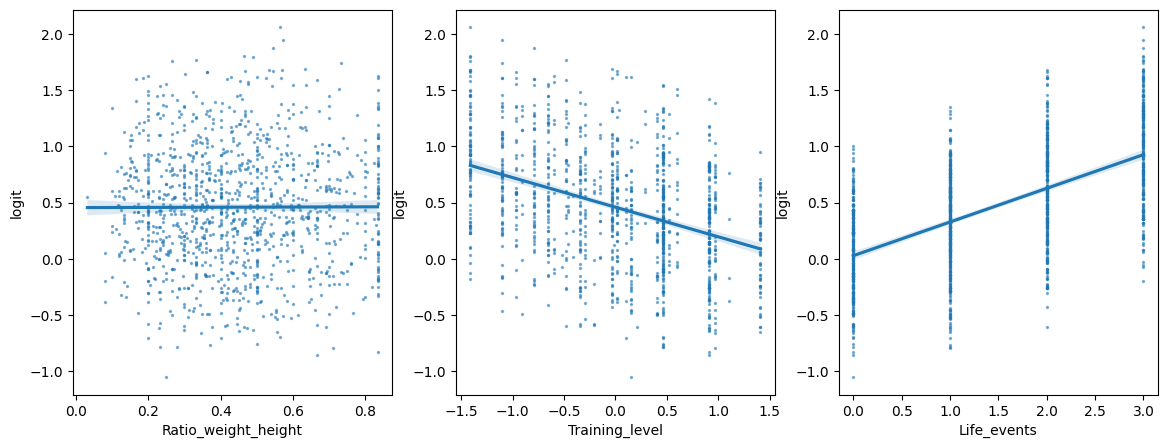

In [25]:
# plot logit of y vs each continuous predictor
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for i in range(len(logit_data.columns) - 1):
    sns.regplot(x=logit_data.columns[i], y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5}, ax = axes[i])

plt.show()

Linearity is considered respected. 